## the activation function 5 softmax: y = exp(u)/sum(exp(u(k,:)), yp(k) = y(k)*(1-y(k)) has bugs. I cannot find what is the problem even I sv = np.mat(np.sum(eu,axis=1)).T into sv = np.mat(np.sum(eu,axis=1)), the dimension problem is still.

## Problem 1

### (a) "self.ActFn = ActFn"

### (b) "para["epoch"] = 16"

### (c) # of rows =5 # of columns = 3

### (d) # of epochs/iter =10 Total # of epochs run till training ends = 1000

## Problem 2

In [7]:
import numpy as np
import pandas as pd

#Read iris.csv
tmp = pd.read_csv('iris.csv').to_numpy()
X = tmp[:,0:4]
[K,d]  = np.shape(X)
C = 3

Label = np.mat([tmp[:,4] == 1, tmp[:,4] == 2,tmp[:,4] == 3]).T

In [8]:
Iv = [[]] * 3
Ir = [[]] * 3
for m in range(3):
    Iv[m] = range(m,K,3) # Indices of 10 validation sets.
    Ir[m] = np.setdiff1d(range(K),Iv[m])

In [43]:
def actfn(u,tp=1, par=1):
    # Usage: [y,yp]=actfunp(u, tp, par)
    # Compute activation functions and their derivatives
    # u: net function, a K x N matrix
    # y: activation function, a K x N matrix
    # tp: 1 - sigmoid, 2 - tanh, 3- linear, 4 - radial 5 - softmax
    #       6 - ReLu,  7, Hardlim (step)
    # par: parameter list
    #    sigmoid: T,  y=1/(1+exp(-u/T)), yp=y*(1-y)/T
    #    tanh: T,     y=(exp(u/T)-exp(-u/T))/(exp(u/T)+exp(-u/T))
    #                 yp=(1-y*y)/T
    #    linear:m,b   y=au+b, yp=a
    #    radial:m,sig y=exp(-(u-m)^2/sig^2), yp=-2(u-m)*y/sig^2
    #    softmax: y = exp(u)/sum(exp(u(k,:)), yp(k) = y(k)*(1-y(k))
    #    ReLU:  y = u if u >0 and = 0 otherwise.  yp = 1 if u > 0 and = 0 o.w.
    #    Step, hardlim: y = 1 if u>=0, = 0 if u < 0, yp = 0 for all u

    (K,N) = np.shape(u)

    if tp == 1:
        T = par
        y = np.reciprocal(1 + np.exp(-u/T))
        yp  = np.multiply(y, np.ones(np.shape(y)) - y)/T
    if tp == 2:
        T = par
        tmp = np.exp(u/T)
        y = np.divide(tmp - np.reciprocal(tmp),tmp + np.reciprocal(tmp))
        yp = (np.ones(np.shape(y)) - np.multiply(y, y))/T
    if tp == 3:
        a = par[0]
        b = par[1]
        y = a*u + b
        yp = a* np.ones(np.shape(y))
    if tp == 4:
        m = par[0]
        sig = par[1]
        s = sig**2
        tmp = np.multiply(u - m, u - m)
        y = np.exp(-tmp/s)
        yp = np.multiply((-2/s) * (u - m), y)
    if tp == 5:
        eu = np.exp(u)
        sv = np.mat(np.sum(eu,axis=1))
        y = np.divide(eu, sv*np.ones((1,N)))
        yp = np.multiply(y,np.ones((K,N)) - y)
    if tp == 6:
        yp = (u > 0).astype(int)
        y = np.multiply(u, yp)
    if tp == 7:
        yp = np.zeros(np.shape(u))
        y = (u >= 0).astype(int)
 
    return y, yp

In [44]:
class mlpdef:
    def __init__(self, d,C,Lsize = [],ActFn=[2,1]):
        if len(Lsize) == 0:
            Lsize = [2, C]
        self.Nlayers = len(Lsize)
        self.Lsize = Lsize
        self.ActFn = ActFn
        self.FeatureDim = d
        self.OutDim = C

        self.W = [[]] * self.Nlayers
        self.W[0] = 0.01 * np.random.randn(d+1, self.Lsize[0])
        for n in range(1,self.Nlayers):
              self.W[n] = 0.01 * np.random.randn(self.Lsize[n-1] + 1, self.Lsize[n])
    
        self.A = [[]] * self.Nlayers
        self.Ap = [[]] * self.Nlayers

    def train(self, X, y, para):
        #Train the network using the backpropagation algorithm.
        #1. setup parameters
        K,d = np.shape(X)
        Kr = para["epoch"]
        dw = [[]] * self.Nlayers
        delta = [[]] * self.Nlayers

        # 2. Start each epoch
        for m in range(para["Nepoch"]):
            # 2a. Draw Kr samples randomly from X for current epoch
            ide  = np.random.choice(range(K),Kr)
            Xr = X[ide,:]
            Lr = y[ide,:]

            # 2b. feed forward output and error
            self.ffnet(Xr)
            # 2c. Delta Error Back-Propagation
            # compute output error and delta errors at each layer
            # delta error is computed for each neuron. The bias input is a constant
            # and has no parent node. and has no delta error. 
            error = Lr - self.A[self.Nlayers - 1]
            delta[self.Nlayers - 1] = np.multiply(self.Ap[self.Nlayers - 1], error)
            for n in reversed(range(self.Nlayers-1)):
                # delta{n}=mlp.Ap{n}.*(delta{n+1}*(mlp.W{n+1}(2:end,:))');
                delta[n] =np.multiply(self.Ap[n],np.dot(delta[n+1], self.W[n+1][1:,:].T))
                # 2d. Weight update
                # initialize weight updates dw using delta error
            dw[0] = np.zeros((d+1, self.Lsize[0]))
            for n in range(1,self.Nlayers):
                dw[n] = np.zeros((self.Lsize[n-1] + 1, self.Lsize[n]))

            one_mat = np.ones((Kr,1))
            dw[0] = np.dot(para["LR"]*np.concatenate((one_mat,Xr),axis=1).T,delta[0]) + np.dot(para["Mom"],dw[0]) + 0.01 * np.random.randn(np.shape(dw[0])[0],np.shape(dw[0])[1])
            self.W[0] += dw[0]
            for n in range(1,self.Nlayers):
                dw[n] = np.dot(para["LR"]*np.concatenate((one_mat,self.A[n - 1]),axis=1).T,delta[n]) + np.dot(para["Mom"],dw[n]) + 0.01 * np.random.randn(np.shape(dw[n])[0],np.shape(dw[n])[1])
                self.W[n] += dw[n]
                                              

    def eval(self, Xr, Lr, Xv, Lv):
        # Evaluate the classification error of the network.
        Kr, C = np.shape(Lr)
        Kv = np.shape(Lv)[0]
        Ic = np.eye(C)
    
        self.ffnet(Xr)
        out = self.A[self.Nlayers -1]
        err_train  = Lr - out
        er = np.sum(np.square(np.sum(err_train))) / np.dot(Kr, C)
        idx = np.argmax(out,axis=1)
        Cmatr = np.dot(Lr.T, Ic[idx, :])

        self.ffnet(Xv)
        out = self.A[self.Nlayers - 1]
        err_test = Lv - out
        et = np.sum(np.square(np.sum(err_train))) / np.dot(Kv, C)
        idx = np.argmax(out,axis=1)
        Cmatt = np.dot(Lv.T, Ic[idx,:])

        return er, et, Cmatr, Cmatt
    
    def ffnet(self, X):
        # Feed data forward through the network.
        K = np.shape(X)[0]
        one_mat = np.ones((K,1))
        u = np.dot(np.concatenate((one_mat,X),axis=1),self.W[0])
        self.A[0], self.Ap[0] = actfn(u,self.ActFn[0])
        for n in range(1,self.Nlayers):
            u = np.dot(np.concatenate((one_mat,self.A[n-1]),axis=1),self.W[n])
            self.A[n], self.Ap[n] = actfn(u,self.ActFn[n])

In [45]:
para = {}
para["LR"] = 0.1
para["Mom"] = 0.8
para["epoch"] = 16
para["Nepoch"] = 10

Training Confusion Matrix: 
[[32.  0.  0.]
 [34.  0.  0.]
 [33.  0.  0.]]
Epoch #: 100
Validation Confusion Matrix: 
[[17.  0.  0.]
 [16.  0.  0.]
 [17.  0.  0.]]
Training Confusion Matrix: 
[[ 0.  0. 32.]
 [ 0.  0. 34.]
 [ 0.  0. 33.]]
Epoch #: 200
Validation Confusion Matrix: 
[[ 0.  0. 17.]
 [ 0.  0. 16.]
 [ 0.  0. 17.]]
Training Confusion Matrix: 
[[ 0. 32.  0.]
 [ 0. 34.  0.]
 [ 0. 33.  0.]]
Epoch #: 300
Validation Confusion Matrix: 
[[ 0. 17.  0.]
 [ 0. 16.  0.]
 [ 0. 17.  0.]]
Training Confusion Matrix: 
[[ 0.  0. 32.]
 [ 0.  0. 34.]
 [ 0.  0. 33.]]
Epoch #: 400
Validation Confusion Matrix: 
[[ 0.  0. 17.]
 [ 0.  0. 16.]
 [ 0.  0. 17.]]
Training Confusion Matrix: 
[[ 0.  0. 32.]
 [ 0.  0. 34.]
 [ 0.  0. 33.]]
Epoch #: 500
Validation Confusion Matrix: 
[[ 0.  0. 17.]
 [ 0.  0. 16.]
 [ 0.  0. 17.]]
Training Confusion Matrix: 
[[ 0.  0. 32.]
 [ 0.  0. 34.]
 [ 0.  0. 33.]]
Epoch #: 600
Validation Confusion Matrix: 
[[ 0.  0. 17.]
 [ 0.  0. 16.]
 [ 0.  0. 17.]]
Training Confusion Mat

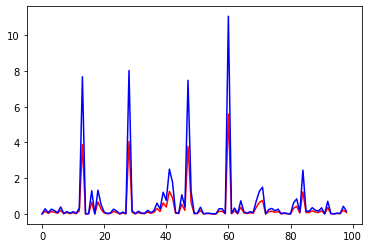

In [50]:
import matplotlib.pyplot as plt

fnet = mlpdef(d,C,[10,C], [6,2])

Xr = X[Ir[0],:]
Lr = Label[Ir[0],:]
Xv = X[Iv[0],:]
Lv = Label[Iv[0],:]

Converged = False
iter = 0
itermax = 100
Er = np.zeros(itermax)
Et = np.zeros(itermax)
while not Converged:
    iter = iter + 1
    fnet.train(Xr, Lr, para)
    Er[iter], Et[iter],Cmatr, Cmatt = fnet.eval(Xr,Lr, Xv, Lv)
    if (iter % 10) == 0:
        print("Training Confusion Matrix: \n" + str(Cmatr))
        print("Epoch #: " + str(iter * para["Nepoch"]))
        print("Validation Confusion Matrix: \n" + str(Cmatt))
    
    if iter >= itermax - 1:
        Converged = True
        print("Reached Max iteration #: " + str(iter) + ", Stop!")

plt.plot(range(iter), Er[range(iter)],'r')
plt.plot(range(iter), Et[range(iter)],'b')
plt.show()

In [51]:
u = np.mat([[1,2,3],[4,6,2]])
u

matrix([[1, 2, 3],
        [4, 6, 2]])

In [35]:
(K,N) = np.shape(u)
eu = np.exp(u)
eu

matrix([[  2.71828183,   7.3890561 ,  20.08553692],
        [ 54.59815003, 403.42879349,   7.3890561 ]])

In [40]:
sv = np.mat(np.sum(eu,axis=1))
sv

matrix([[ 30.19287485],
        [465.41599962]])

In [41]:
y = np.divide(eu, sv*np.ones((1,N)))
y

matrix([[0.09003057, 0.24472847, 0.66524096],
        [0.11731043, 0.86681333, 0.01587624]])

In [48]:
yp = np.multiply(y,np.ones((K,N)) - y)
yp

matrix([[0.08192507, 0.18483645, 0.22269543],
        [0.10354869, 0.11544798, 0.01562418]])